In [1]:
import numpy      as     np
from   scipy      import stats  as stats
from   matplotlib import pyplot as plt

In [2]:
num_train  = int(1e5)
noise_size = 100

train_masses = [120., 130., 140.]
train_sigmas = [1.5 ]

train_pairs = []
for m in train_masses :
    for s in train_sigmas :
        train_pairs.append((m, s))
num_pairs = len(train_pairs)

In [3]:
range_min, range_max = 105, 160
range_width = range_max - range_min
plot_resolution = 0.25

m1, s1 = 125., 1.8

def true_pdf (x) :
    return stats.norm.pdf(x, m1, s1)

def true_cdf (x) :
    return stats.norm.cdf(x, m1, s1)

In [4]:
def generate_data (num_pnts, mass=125., sigma=1.8, resolution=0.01) :
    global m1, s1
    m1 = mass
    s1 = sigma
    x = np.linspace(range_min, range_max, 1+int(1./resolution))
    y = true_cdf(x)
    p = np.random.uniform(0, 1, size=(num_pnts,))
    return np.interp(p, y, x)

In [5]:
def plot_points (DS, label="") :
    x = np.linspace(range_min, range_max, 1000)
    histos = []
    for idx, ds in enumerate(DS) :
        p = train_pairs[idx]
        h = plt.hist(ds, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), density=True, label=r" ($m="+f"{p[0]:.0f}"+r", \sigma = "+f"{p[1]:.1f}"+"$)")
        histos.append(h)
    if len(label) > 0 : plt.title(label)
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=15)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=35, rotation="horizontal")
    plt.gca().set_xlim([range_min, range_max+0.3*range_width])
    plt.gca().set_ylim([0, 1.1*max([max(h[0]) for h in histos])])
    plt.show()

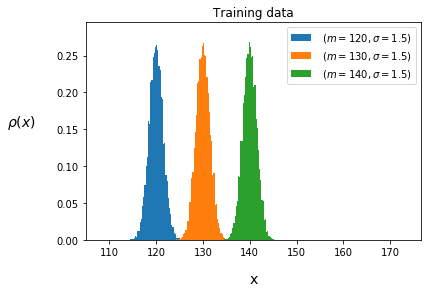

In [6]:
train_DS = []
for p in train_pairs :
    train_DS.append(generate_data(num_train, mass=p[0], sigma=p[1]))
plot_points(train_DS, "Training data")

In [7]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD

import keras.backend as K


d1_in = Input((1,))
d1 = Dense(30)(d1_in)
d1 = LeakyReLU(0.2)(d1)
d1 = Dropout(0.2)(d1)

hyper_in = Input((2,))
d2 = Dense(20)(hyper_in)
d2 = LeakyReLU(0.2)(d2)
d2 = Dropout(0.2)(d2)

dc = Concatenate()([d1, d2])
dc = Dense(40)(dc)
dc = LeakyReLU(0.2)(dc)
dc = Dropout(0.2)(dc)
dc = Dense(2, activation="softmax")(dc)

dc = Model(name="Discriminator", inputs=[d1_in, hyper_in], outputs=[dc])
dc.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
# 0.0005, beta_1=0.5
dc.summary()


g1_in = Input((noise_size,))
g1 = Dense(20, activation="relu")(g1_in)
g1 = BatchNormalization()(g1)

g2 = Dense(20, activation="relu")(hyper_in)
g2 = BatchNormalization()(g2)

gc = Concatenate()([g1, g2])
gc = Dense(40, activation="relu")(gc)
gc = Dense(1, activation="linear")(gc)

gc = Model(name="Generator", inputs=[g1_in, hyper_in], outputs=[gc])
gc.summary()


gan_out = dc([gc([g1_in, hyper_in]), hyper_in])
gan = Model([g1_in, hyper_in], gan_out, name="GAN")
dc.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           60          input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           60          input_2[0][0]                    
______________

In [8]:
def plot_points_GAN (gen_data, train_data, epoch, d_acc) :
    num_classes = len(train_pairs)
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1, 2, 1)
    histos = []
    gen_data_per_class = int(len(gen_data) / num_classes)
    for idx in range(num_classes) :
        p = train_pairs[idx]
        ds_i = idx * gen_data_per_class
        ds_f = (1+idx) * gen_data_per_class
        h = plt.hist(gen_data[ds_i:ds_f], bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), density=True, label=r" ($m="+f"{p[0]:.0f}"+r", \sigma = "+f"{p[1]:.1f}"+"$)")
        histos.append(h)
    plt.title("Generated data")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.05*range_width, range_max+0.3*range_width])
    y_max = 1.5*np.max([max(h[0]) for h in histos])
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.890*1.1*range_width, 0.30*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.823*1.1*range_width, 0.23*y_max, f"Batch size: {gen_data_per_class}")
    plt.text(range_min+0.920*1.1*range_width, 0.16*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    fig.add_subplot(1, 2, 2)
    histos = []
    train_data_per_class = int(len(train_data) / num_classes)
    for idx in range(num_classes) :
        p = train_pairs[idx]
        ds_i = idx * train_data_per_class
        ds_f = (1+idx) * train_data_per_class
        h = plt.hist(train_data[ds_i:ds_f], bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), density=True, label=r" ($m="+f"{p[0]:.0f}"+r", \sigma = "+f"{p[1]:.1f}"+"$)")
        histos.append(h)
    plt.title("Training data")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.05*range_width, range_max+0.3*range_width])
    y_max = 1.5*np.max([max(h[0]) for h in histos])
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.890*1.1*range_width, 0.30*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.823*1.1*range_width, 0.23*y_max, f"Batch size: {train_data_per_class}")
    plt.text(range_min+0.920*1.1*range_width, 0.16*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


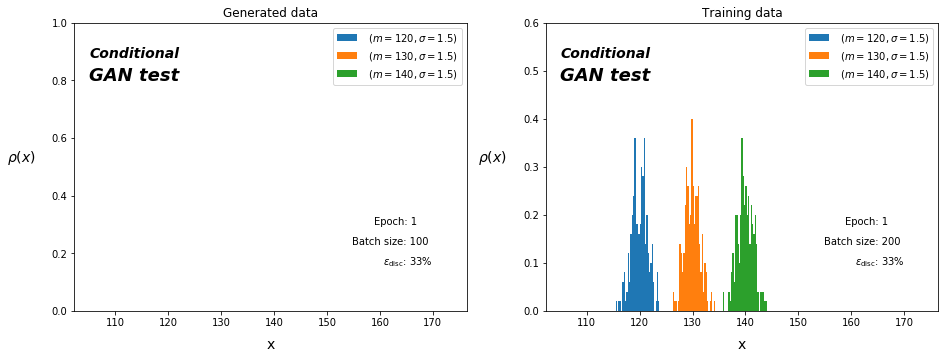

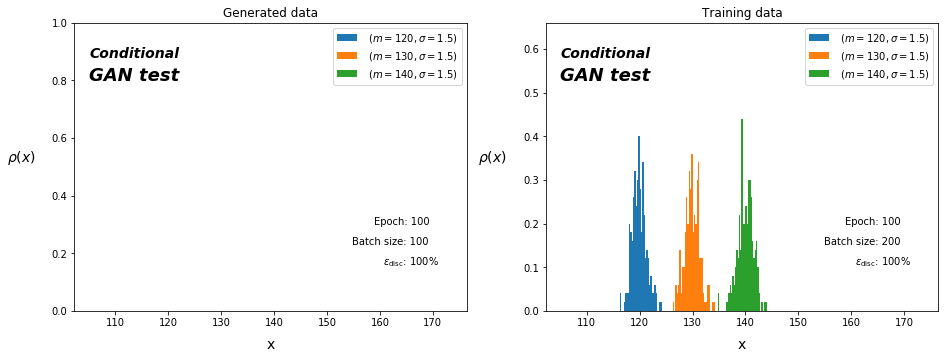

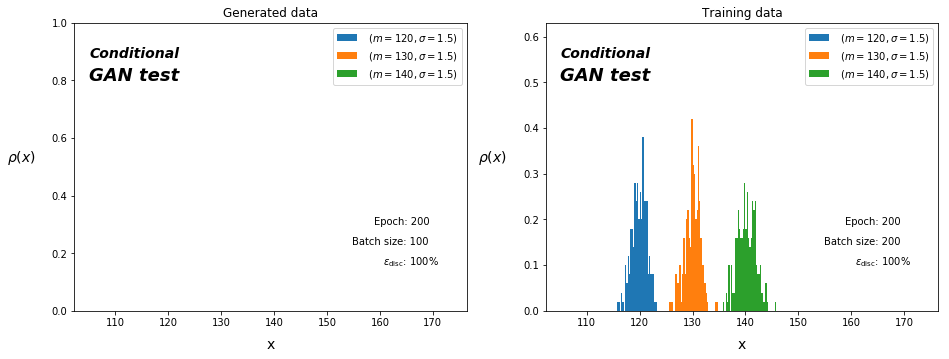

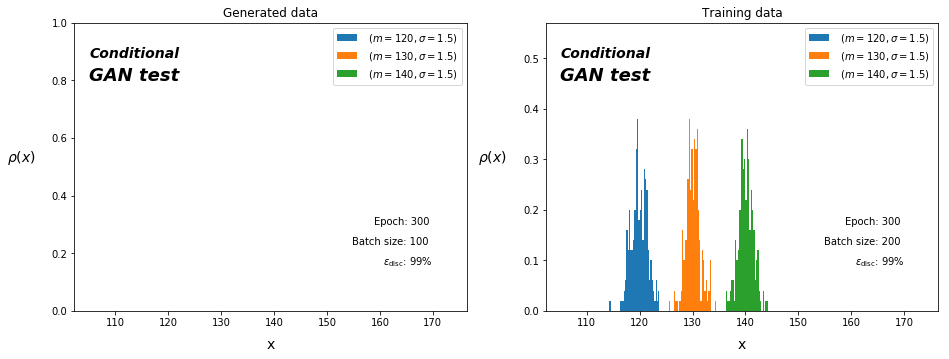

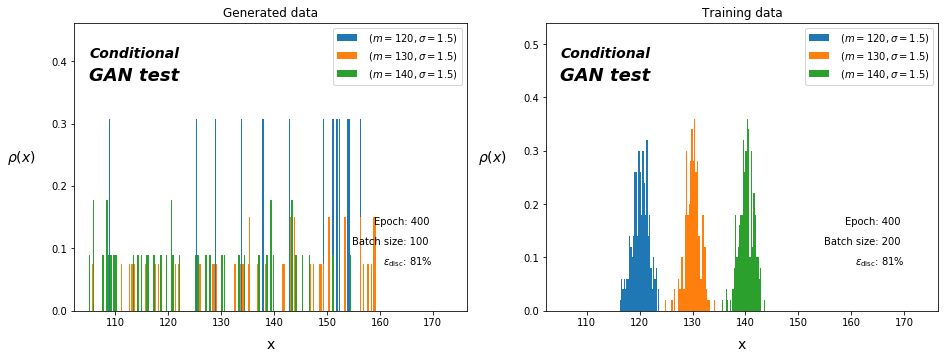

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a607c7f47296>", line 64, in <module>
    d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
  File "<ipython-input-8-07ed5c218792>", line 11, in plot_points_GAN
    h = plt.hist(gen_data[ds_i:ds_f], bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), density=True, label=r" ($m="+f"{p[0]:.0f}"+r", \sigma = "+f"{p[1]:.1f}"+"$)")
  File "/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2659, in hist
    **({"data": data} if data is not None else {}), **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 6667, in hist
    color=c, **{bottom_kwarg: bottom})
  Fil

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11e056510> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11e062e18> (for post_execute):


KeyboardInterrupt: 

In [9]:
#  Train GAN

epochs     = 10000
batch_size = 100
rel_batch_size = 2
max_D_itrs_per_G_itr_e80 = 2
max_D_itrs_per_G_itr_e52 = 0

def update_batch_size (gen_DS, e) :
    global batch_size
    batch_size = min(max(batch_size, 50+int((e+1)/17.)), num_train)

def get_hyperparams (length=-1) :
    if length < 0 : length = batch_size
    ret = []
    for p in train_pairs :
        hyperparams = np.array(list(p))
        ret.append(np.full(fill_value=hyperparams, shape=(length, 2)))
    return np.concatenate(ret)
        
def get_noise () :
    return np.random.normal(size=(len(train_pairs)*batch_size, noise_size)), get_hyperparams()

def get_train_data () :
    DS = []
    for ds in train_DS :
        DS.append(ds[np.random.randint(0, num_train, rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1))
    return np.concatenate(DS), get_hyperparams(rel_batch_size*batch_size)
  
epochs_saved = []
for e in range(epochs) :
    noise   , noise_hyperparams = get_noise()
    batch_DS, batch_hyperparams = get_train_data()
    gen_DS   = gc.predict([noise, noise_hyperparams])
    real_label  = np.array([[1., 0.] for i in range(num_pairs*rel_batch_size*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(num_pairs*batch_size)])
    train_label = np.array([[1., 0.] for i in range(num_pairs*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
    num_itr = 0
    while num_itr < max_D_itrs_per_G_itr_e80 and d_acc < 0.8 :
        d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
        num_itr = num_itr + 1
    while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
        d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
        num_itr = num_itr + 1
        
    noise, noise_hyperparams = get_noise()
    dc.trainable = False
    gan.train_on_batch([noise, noise_hyperparams], train_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise, noise_hyperparams = get_noise()
        gen_DS = gc.predict([noise, noise_hyperparams])
        plot_points_GAN(
                    gen_DS,
                    batch_DS,
                    epoch=e+1, 
                    d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
        update_batch_size(gen_DS, e)
        epochs_saved.append(e+1)



In [ ]:
mass = 140.

hyperparams = np.full(fill_value=mass, shape=(10000, 1))
z = np.random.normal(size=(10000, noise_size))
datapoints = gc.predict([z, hyperparams])[:,0]

plt.hist(datapoints, bins=np.linspace(min(datapoints)-10, max(datapoints)+10, 401))
plt.show()

print(f"          MASS = {mass}")
print(f"GENERATED MEAN = {np.mean(datapoints):.1f}")

In [ ]:
def reset_weights(model):
    model.trainable = True
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

reset_weights(dc)


In [ ]:
for e in range(100) :
    noise   , noise_hyperparams = get_noise()
    batch_DS, batch_hyperparams = get_train_data()
    gen_DS   = gc.predict([noise, noise_hyperparams])
    real_label  = np.array([[1., 0.] for i in range(num_pairs*rel_batch_size*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(num_pairs*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
    print(d_loss, d_acc)